Now you have an idea of how to create plots for sentiment analysis performed by BERT models. But how can we be sure that the differences we observe between groups are meaningful? Perhaps these differences are due to chance or too small to be significant. To address these questions we introduce statistical significance testing. For these analyses we will be using the Mann-Whitney *U* test, which tests the null hypothesis that two independent samples (*X* and *Y*) belong to the same underlying distribution. There are many significance tests that could be used (*t*-tests, ANOVA, etc.), but the Mann-Whitney *U* test was chosen for its non-parametric nature: it makes no assumptions about the distribution of the data.

For this exercise, we'll look at a dataset containing 195 countries. Two columns categorical columns are provided: Continent and Income level. Continent categorizes a country as belonging to Europe, Africa, North America, South America, Asia, and Oceania. For the sake of this exercise, Caribbean and Central American countries were assigned to North America, while Middle Eastern countries were assigned to Asia. Income level contains four categories: High, Upper middle, Lower middle, and Low. These categories are defined based on per capita gross national income (GNI) for the 2026 fiscal year, where Low is \\$1,135 or less, Lower middle is between \\$1,136 and \\$4,495, Upper middle is between \\$4,496 and \\$13,935, and High is \\$13,935 or more. These categories were assigned by the World Bank to all countries except for Ethiopia and Venezuela; for those cases I assigned labels based on the most recent data I could find.

Sentiment analysis was performed for the all the Wikipedia articles in the dataset with the BERT, RoBERTa, and RoBERTuito models using analyze_csv. Let's take a look at trends by grouping for the dataset and determine their significance. Let's first generate a plot based on grouping by Continent.

In [1]:
from sentiment_plots import plot_group

In [2]:
models=['bert','roberta','robertuito'] #models you used previously when predicting sentiment. May use all or only some
input_filename='countries_analysis.csv' #analysis csv file you wish to use for plotting
plot_metric='avg_article_prob'
group_cols=['Continent']
group_values=True

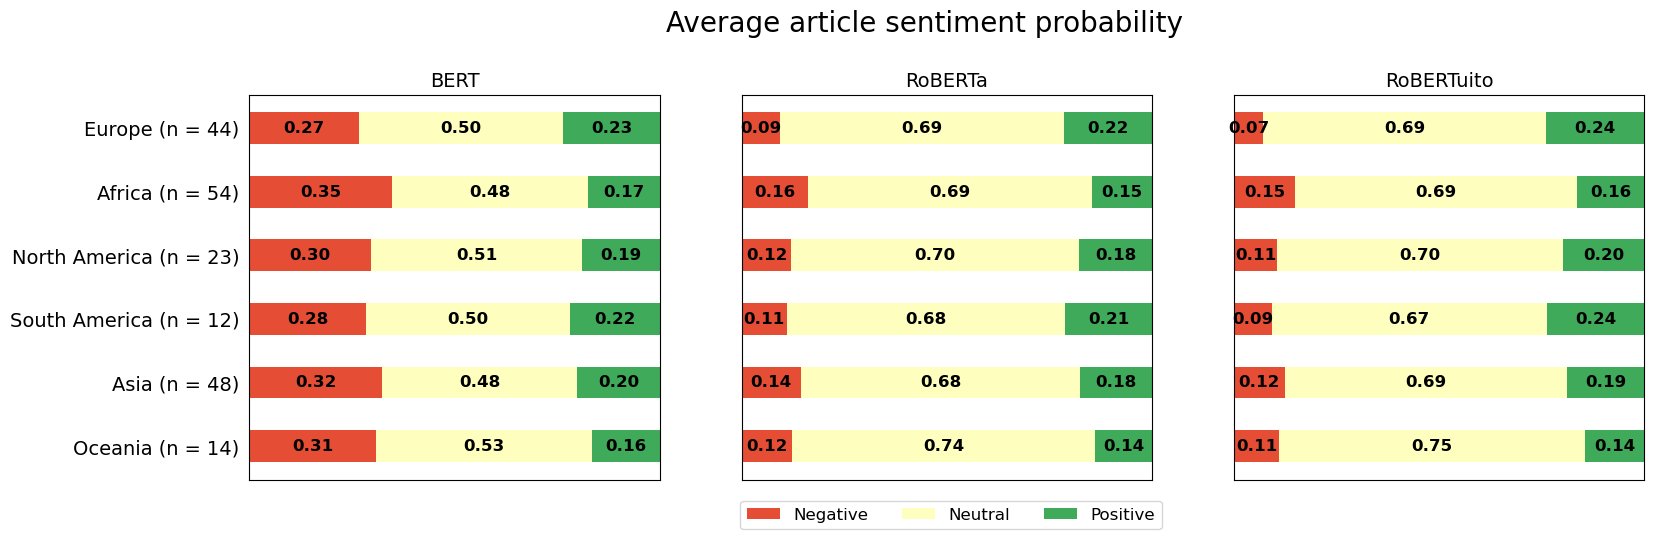

In [3]:
plot_group(models,input_filename,group_cols,save_fig=False,group_values=group_values,plot_metric=plot_metric)

It looks like there could be some differences between groups, but let's use our significance test to confirm whether that's the case.

In [4]:
from sentiment_significance import significance_test

There are two new parameters to consider here: metric and effect_size_metric. The metric parameter determines whether to look at weighted article probabilities ('weighted_prob') or percent of paragraphs by sentiment ('paragraph_percent'). The effect_size_metric parameter has two options: 'f' and 'r'. Here 'f' represents the common language effect size, which is the U1 statistic divided by the product of the two sample sizes. Intuitively, it may be understood as the percent of possible pairs of *X* and *Y* for which *X* is greater than *Y*. It ranges in value between 0 and 1. The 'r' option represents the rank-biserial correlation, which may be understood as the common language effect size subtracted by the percent of possible pairs of *X* and *Y* for which *Y* is greater than *X*. It ranges between -1 and 1.

In [5]:
metric='weighted_prob'
effect_size_metric='f'

Now let's return p-values and effect sizes for the groups that we generated in the plots above.

In [6]:
p_dict,effect_dict=significance_test(models,input_filename,group_cols,group_values,metric,effect_size_metric)

The p-values and effect sizes are returned as dictionaries of pandas dataframes which allow for easy viewing. The dictionaries are organized according to a model key (e.g., 'bert') and then a sentiment key (e.g., 'positive'). Any model that is called must have been used during the original analysis. Since the Mann-Whitney *U* test is only applicable between two samples, each dataframe contains all the pairwise combinations of groups for the same model and sentiment. As an example, let's look at p-values for the BERT model and negative sentiment.

In [7]:
p_dict['bert']['negative']

,Europe,Africa,North America,South America,Asia,Oceania
Europe,1.000000e+00,3.563658e-09,0.045436,0.153373,8.982512e-09,0.120279
Africa,3.563658e-09,1.000000e+00,0.002250,0.002160,2.204892e-02,0.056978
North America,4.543637e-02,2.249884e-03,1.000000,0.741288,2.055459e-02,0.937597
South America,1.533732e-01,2.159722e-03,0.741288,1.000000,1.756092e-02,0.699676
Asia,8.982512e-09,2.204892e-02,0.020555,0.017561,1.000000e+00,0.203690
Oceania,1.202789e-01,5.697761e-02,0.937597,0.699676,2.036900e-01,1.000000


Note that all diagonal terms are equal to 1 since *X* and *Y* are identical. Now let's look at the pair of Asia and Europe. The p-value is 8.98e-09, so if we assume a threshold of 0.05 we can conclude that the null hypothesis is easily rejected. In other words, when considering the article probabilities of negative sentiment using the BERT model, we can say that the articles of Asian countries and the articles of European countries do not belong to the same probability distribution. However, the p-value by itself has nothing to say about the size or directionality of the relationship. To gain a better understanding of this, we will need to look at the effect sizes. 

In [8]:
effect_dict['bert']['negative']

,Europe,Africa,North America,South America,Asia,Oceania
Europe,0.500000,0.151936,0.349802,0.363636,0.151515,0.360390
Africa,0.848064,0.500000,0.721417,0.785494,0.631944,0.666667
North America,0.650198,0.278583,0.500000,0.536232,0.328804,0.490683
South America,0.636364,0.214506,0.463768,0.500000,0.276042,0.452381
Asia,0.848485,0.368056,0.671196,0.723958,0.500000,0.613095
Oceania,0.639610,0.333333,0.509317,0.547619,0.386905,0.500000


The values of *f* allow for more insight into sentiment relationships. We can see that the Europe-Asia value is approximately 0.15, which means that for all possible pairs of European and Asian Wikipedia articles, the BERT model found a higher negative sentiment probability for the European article 15% of the time. Also notice that the Asia-Europe value is approximately 0.85, or 1 minus the Europe-Asia value. Let's do another similar analysis, but this time let's look at Income level instead of Continent and percent of paragraphs rather than article probability.

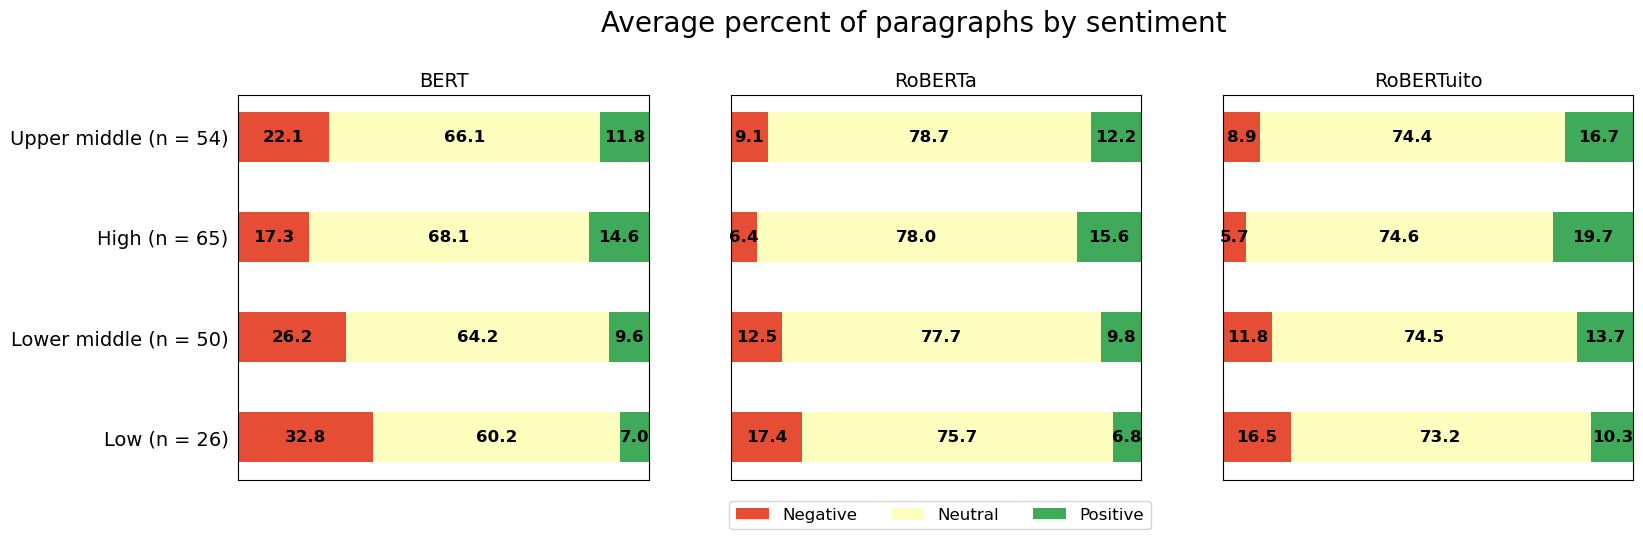

In [9]:
group_cols=['Income level']
group_values=True
plot_metric='avg_paragraph_percent'
plot_group(models,input_filename,group_cols,save_fig=False,group_values=group_values,plot_metric=plot_metric)

Let's choose the rank-biserial correlation to capture effect size this time.

In [10]:
metric='paragraph_percent'
p_dict,effect_dict=significance_test(models,input_filename,group_cols,group_values,metric,effect_size_metric='r')

Let's look at the p-values for percent of paragraphs with positive sentiment using the RoBERTa model.

In [11]:
p_dict['roberta']['positive']

,Upper middle,High,Lower middle,Low
Upper middle,1.000000,2.034555e-03,8.495753e-03,1.638097e-05
High,0.002035,1.000000e+00,1.410634e-07,3.850295e-09
Lower middle,0.008496,1.410634e-07,1.000000e+00,7.430674e-02
Low,0.000016,3.850295e-09,7.430674e-02,1.000000e+00


Income level is clearly significant: for a threshold of 0.05 the null hypothesis is rejected for all pairs!

In [12]:
effect_dict['roberta']['positive']

,Upper middle,High,Lower middle,Low
Upper middle,0.000000,-0.329630,0.300000,0.598291
High,0.329630,0.000000,0.574462,0.794083
Lower middle,-0.300000,-0.574462,0.000000,0.251538
Low,-0.598291,-0.794083,-0.251538,0.000000


And now we can get a better idea of the directionality and magnitude of the differences. Look at the High row: it has higher positive sentiment compared to all other categories, and the magnitude increases as its compared to increasingly poor categories. In other words, poorer countries receive less positive sentiment in their Wikipedia articles, and we know that these differences are statistically significant. Finally, let's look a case in which countries are grouped by both Continent and Income level. We'll allow all countries from Asia and Europe and all income levels with a minimum group size of 5.

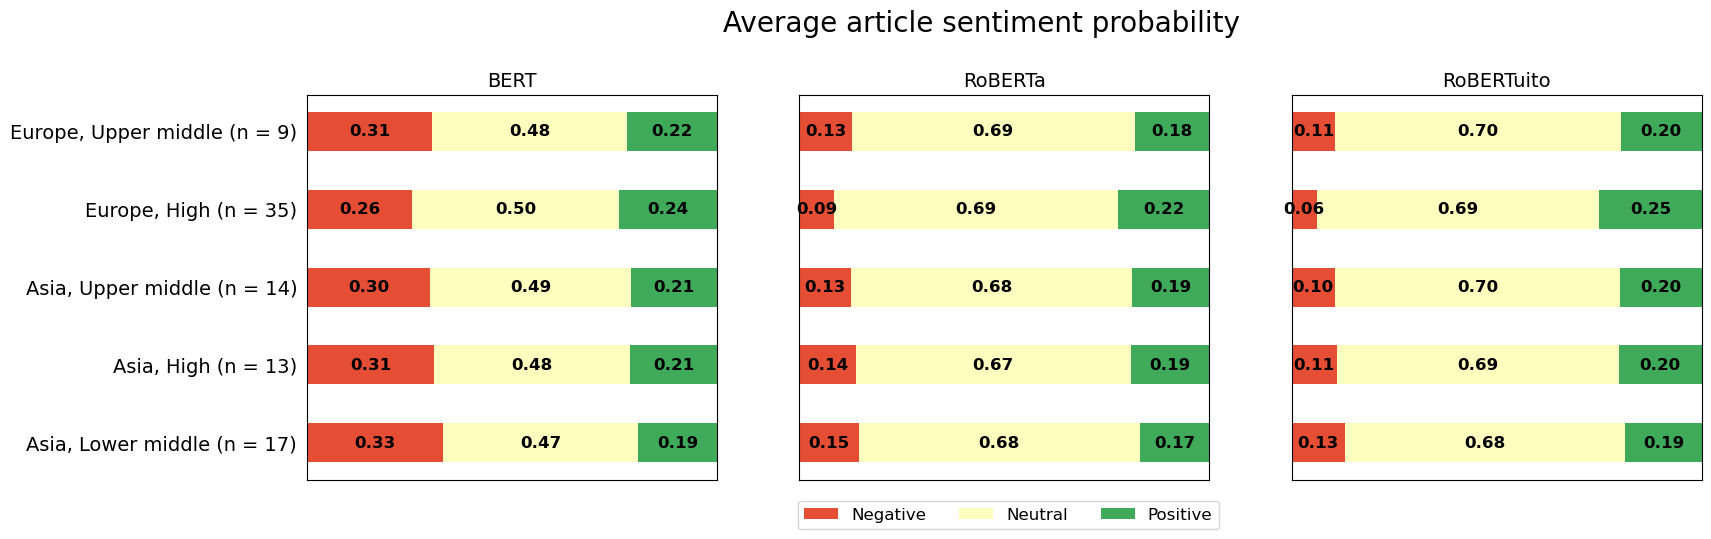

In [13]:
group_cols=['Continent','Income level']
group_values=[['Asia','Europe'],True]
plot_metric='avg_article_prob'
min_group_size=5
plot_group(models,input_filename,group_cols,save_fig=False,group_values=group_values,plot_metric=plot_metric,min_group_size=min_group_size)

Just like plot_group, significance_test admits a min_group_size argument that sets a minimum sample size for a group to be considered.

In [14]:
metric='weighted_prob'
p_dict,effect_dict=significance_test(models,input_filename,group_cols,group_values,metric,effect_size_metric='f',min_group_size=min_group_size)

Now let's look at neutral sentiment probability using the RoBERTuito model.

In [15]:
p_dict['robertuito']['neutral']

,"Europe, Upper middle","Europe, High","Asia, Upper middle","Asia, High","Asia, Lower middle"
"Europe, Upper middle",1.000000,0.503367,1.000000,0.688664,0.450516
"Europe, High",0.503367,1.000000,0.650050,0.944512,0.984437
"Asia, Upper middle",1.000000,0.650050,1.000000,0.610385,0.619769
"Asia, High",0.688664,0.944512,0.610385,1.000000,0.900084
"Asia, Lower middle",0.450516,0.984437,0.619769,0.900084,1.000000


Notice how much higher these p-values are compared to the values we observed previously. For all pairs of groups, the null hypothesis was never rejected for a threshold value of 0.05. This makes sense: we can see from the figure that the neutral probability showed very low variance between groups. We can look at the effect sizes for confirmation.

In [16]:
effect_dict['robertuito']['neutral']

,"Europe, Upper middle","Europe, High","Asia, Upper middle","Asia, High","Asia, Lower middle"
"Europe, Upper middle",0.500000,0.574603,0.500000,0.555556,0.594771
"Europe, High",0.425397,0.500000,0.457143,0.507692,0.497479
"Asia, Upper middle",0.500000,0.542857,0.500000,0.560440,0.554622
"Asia, High",0.444444,0.492308,0.439560,0.500000,0.515837
"Asia, Lower middle",0.405229,0.502521,0.445378,0.484163,0.500000


The *f* values in this case are close to 0.5, which makes sense. This small study has demonstrated that positive and negative sentiment vary in statistically significant ways with respect to Income level in all cases and Continent in some cases, but neutral sentiment is quite steady.